## Problem Statement

Krittika's Python tutorial notebooks: https://github.com/krittikaiitb/tutorials <br><br>
A Cepheid variable is a type of star that, due to some inherent instability, pulsates radially, varying in both diameter and temperature and producing changes in brightness with a well-defined stable period and amplitude. As it turns out, the period of pulsation and the Luminosity (i.e the absolute magnitude) of the Cephied are related. <br><br>
We'll use data of cepheids from the Small Magallenic Cloud (SMC) obtained by a survey called Optical Gravitational Lensing Experiment (OGLE).The Small Magellanic Cloud is a dwarf galaxy satellite of the Milky Way, and distances to any star in it can be assumed to be almost constant. So the magnitudes translated directly into absolute magnitudes with some offset dependent on the distance to the SMC!

### Data Cleaning

The data file given consists of 'ID', the identifier for the star; 'RA', the right ascension in HMS format; 'Decl', the declination in DMS format; 'I' , the I band magnitude; 'V', the V band magnitude; 'P_1', the period. <br><br>
Some entries in the V and I band magnitude have a value of -99.990, so we do not want to use these stars for further analysis. Remove such entries. Further, convert the RA and Dec values to degrees from HMS and DMS respectively. You might find Pandas convenient for the above purposes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord as scr
import astropy.units as u
import scipy.optimize as sco

In [2]:
#DATA IS IMPORTED TO A DATAFRAME
df = pd.read_csv("CepheidData.csv", delimiter=',').drop(['ID'], axis=1)
len(df)

2754

In [3]:
#DATA IS CLEANED
#THE ID COLUMN AND V, I MAGNITUDES AT -99.990 ARE DROPPED
df = df.drop(df[(df.V <= -99.990) | (df.I <= -99.990)].index)
len(df)

2637

Plot the RA, Dec coordinates in a sky grid using Matplotlib. (Hint: Look up Mollweide projections in Matplotlib)

In [4]:
#COORDINATE CONVERSION FOR PLOTTINF IN VARIOUS PROJECTIONS
coord = scr(df.RA.values, df.Decl.values, unit =(u.hour, u.degree), frame = 'icrs')
df.RA.values
df.RA = coord.ra.value
df.Decl = coord.dec.value

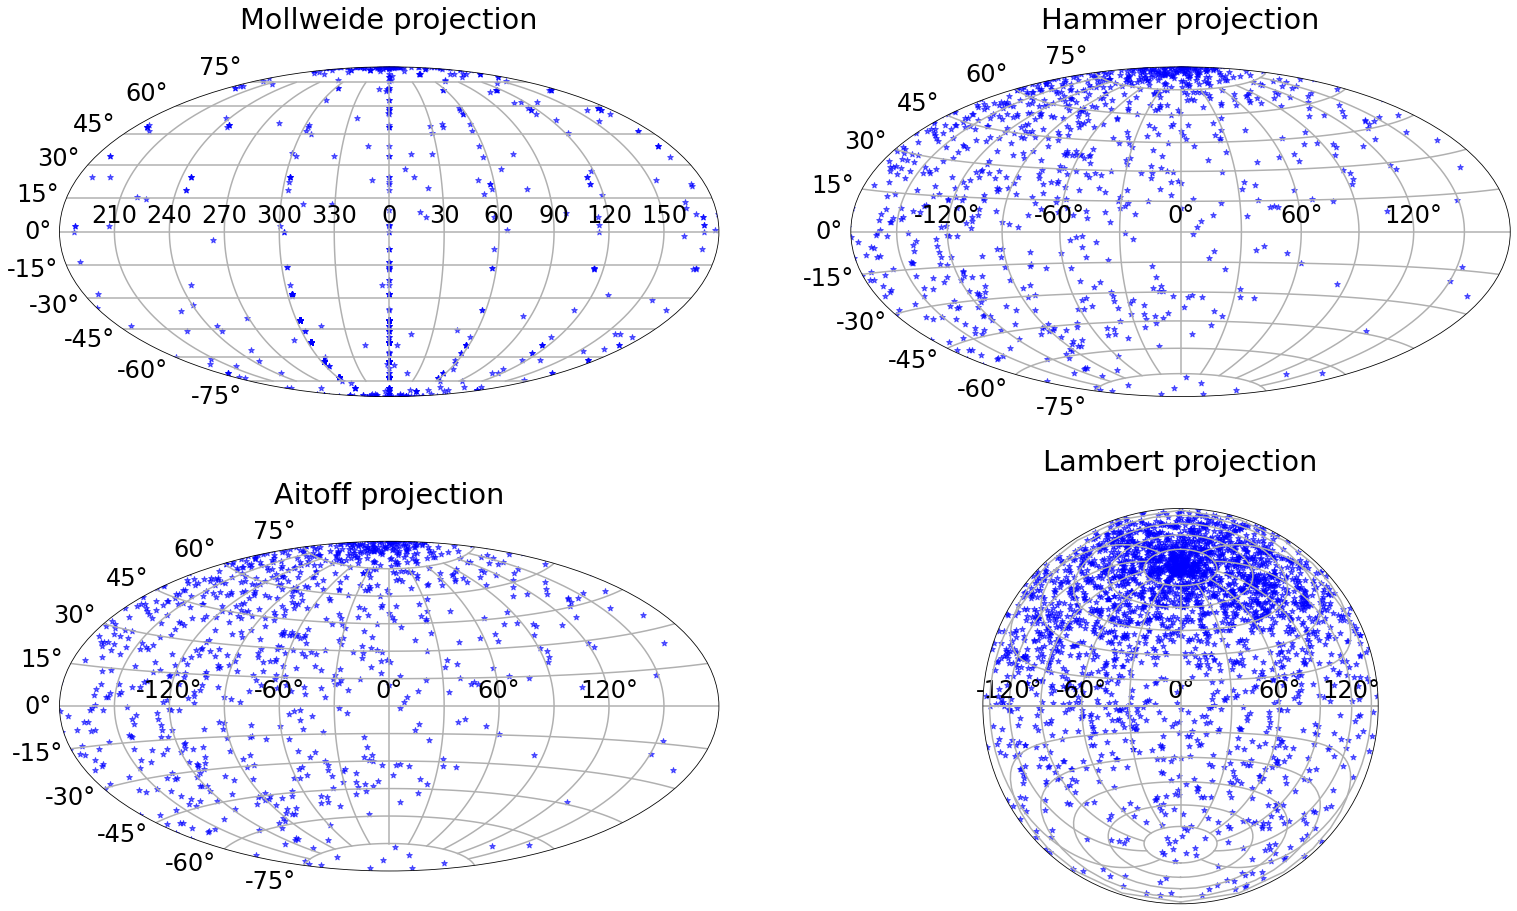

In [5]:
#PLOTTING IN 4 BUILTIN PROJECTIONS
plt.figure(figsize=(26,16))
plt.rc('font', size=24)
for (i, projection) in enumerate(['Mollweide', 'Hammer', 'Aitoff', 'Lambert']):

    ax = plt.subplot(221 + i, projection = projection.lower())
    
    if projection == 'Mollweide':
        x = np.remainder(df.RA+360,360) # shift RA values
        ind = x>180
        x[ind] -=360    # scale conversion to [-180, 180]
        tick_labels = np.array([210, 240, 270, 300, 330, 0, 30, 60, 90, 120, 150])
        ax.set_xticklabels(tick_labels)
        plt.scatter(coord.ra.hms, coord.dec.dms, c='b', marker= '*', alpha=0.6)
        
    else:
        ax.xaxis.set_major_locator(plt.FixedLocator(np.pi / 3 * np.linspace(-2, 2, 5)))
        ax.xaxis.set_minor_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-5, 5, 11)))
        ax.yaxis.set_major_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-2, 2, 5)))
        ax.yaxis.set_major_locator(plt.FixedLocator(np.pi / 12 * np.linspace(-5, 5, 11)))
        plt.scatter(df.RA.values, df.Decl.values, c='b', marker= '*', alpha=0.6)
        

    ax.set_title(f'{projection} projection\n')
    ax.grid(True, which='both', lw = 1.5)
plt.show()

### P-L Diagrams

Plot the Magnitude vs log(Period) for V and I bands. Observe that a linear fit can be done to obtain the period magnitude relation for each band separately. Use scipy's curve fit module to obtain the relation for both V and I band. The P-L relation is of the form <br><br>
$m_{\lambda} = a_{\lambda}log(P) + I_{\lambda}$ <br><br>
where $m_{\lambda}$ is the apparent magnitude, $a_{\lambda}$ is the slope, P is period and $I_{\lambda}$ is the intercept

In [6]:
#mag[0] STORES V BAND AND mag[1] STORES I BAND MAGNITUDES
mag = [df.V.values, df.I.values]
df.P_1 =np.log10(df.P_1.values * 86400)

In [7]:
#USING LEAST SQUARE METHOD TO FIND THE GLOBAL LINEAR FIT i.e, A LINEAR FIT FOR THE ENTIRE DATA
A = np.vstack([df.P_1.values, np.ones(len(df.P_1.values))]).T
par2 = [np.linalg.lstsq(A, mag[i], rcond=None)[0] for i in [0,1]]

#STORING THE GLOBAL VALUES OF SLOPE AND INTERCEPT FOR V BAND AND I BAND
v_global_slp , v_global_int = par2[0]
i_global_slp , i_global_int = par2[1]

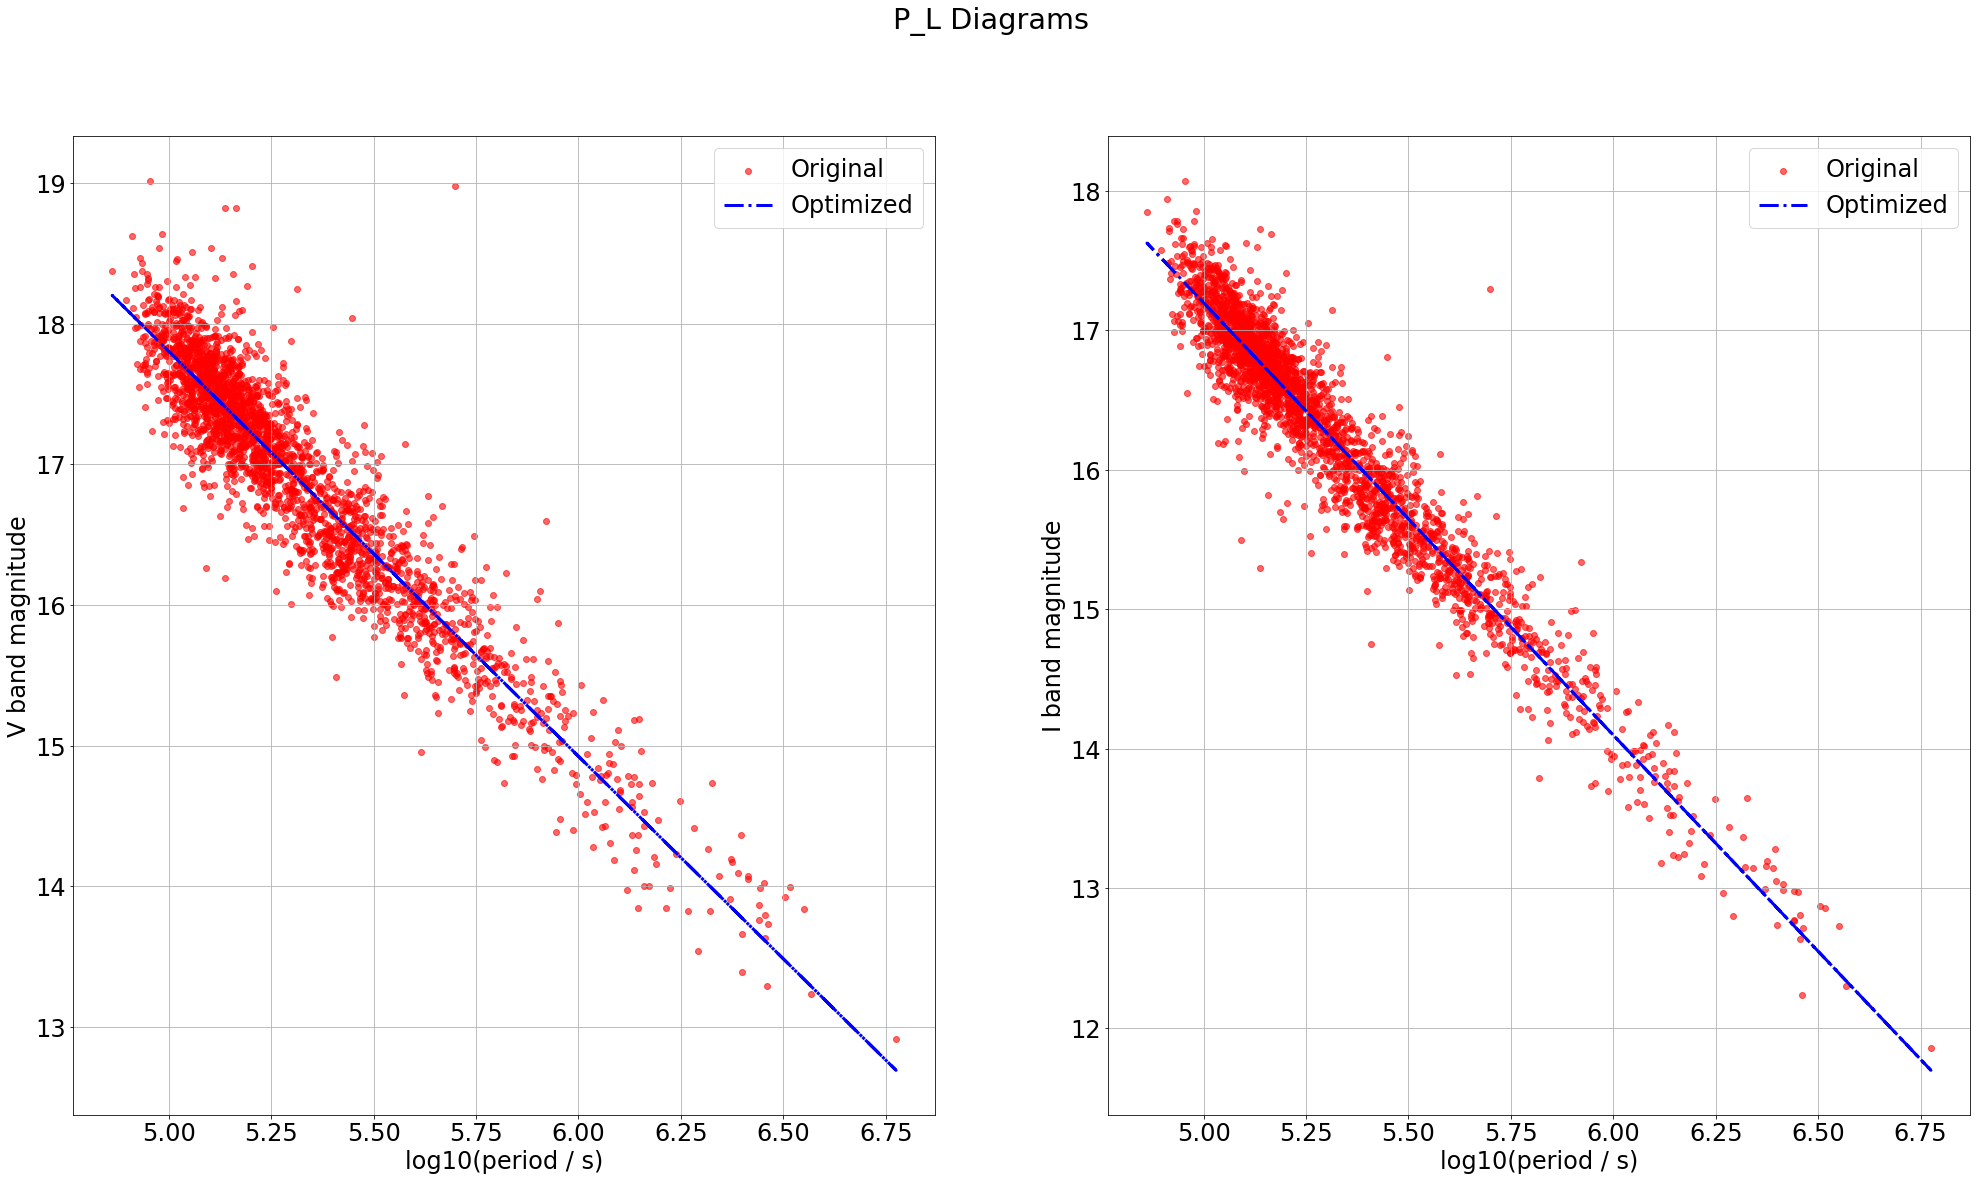

In [8]:
#PLOTTING THE MAGNITUDE vs LOG10(PERIOD) FOR V AND I BANDS
plt.figure(figsize=(34,18))
for i, c in enumerate(['V', 'I']):
    ax = plt.subplot(121 + i)
    ax.set_xlabel('log10(period / s)')
    ax.set_ylabel(f'{c} band magnitude')
    ax.scatter(df.P_1.values, mag[i], color='r', marker = 'o', alpha=0.6, label = "Original")
    ax.plot(df.P_1.values, par2[i][0] * df.P_1.values + par2[i][1], color='b', lw=3, ls = '-.', label="Optimized")
        
    ax.grid(True, which='both')
    ax.legend()
plt.suptitle("P_L Diagrams")
plt.show()

### Deviation

From the P-L diagrams, you can observe that there are quite a few stars that deviate from the linear fit, in both bands. A naive attempt at quantifying the deviation from the P-L relation would be by splitting the region the cepheids are contained in into multiple patches and calculating the fit parameters in each patch. Assume that the change in slope value is negligible. This leaves only the intercept, implying that the new fit is a vertical offset from the global fit done earlier. <br><br>

Divide the SMC region into 25 patches. You can do this by simply partitioning the RA and Dec ranges into 5 parts each. Each patch would look somewhat similar to the reference image below (not related to SMC data). Make sure that you do not include outliers while partitioning RA and Dec. Quantiles can be used to change the range containing 5% to 95% of all entries. <br><br>

![Sky Grid](Sky_Grid).png

Write a function to perform a linear fit to both V and I bands in each patch and return the intercept values. We calculate the deviation as <br><br>

$D_{V-I} = (GI_V - I_V) - (GI_I - I_I)$ <br><br>

where GI is the Grid Intercept (intercept values in each grid) and I is the intercept (global intercept from the previous part). The bands are in given in the subscripts. You will obtain 25 values of $D_{V-I}$, one for each patch. Plot a histogram of these values.

In [9]:
#THIS FUNCION RETURNS THE SHORTEST DISTANCE BETWEEN A POINT AND A LINE GIVEN THE COEFFICIENTS OF THE LINE AND THE COORDINATES OF THE POINT
def shortest_distance(x1, y1, a, c):    
      
    return np.subtract(a * x1 , np.subtract(y1 , c * np.ones(len(y1)))) / float(np.sqrt(a * a + 1))

In [10]:
#FINDING THE OUTLIERS AS MENTIONED IN THE ABOVE MARKDOWN CELL
vlow = np.quantile(shortest_distance(df.P_1.values,df.V.values, par2[0][0], par2[0][1]), 0.05)
vhi = np.quantile(shortest_distance(df.P_1.values,df.V.values, par2[0][0], par2[0][1]), 0.95)
ilow = np.quantile(shortest_distance(df.P_1.values,df.I.values, par2[1][0], par2[1][1]), 0.05)
ihi = np.quantile(shortest_distance(df.P_1.values,df.I.values, par2[1][0], par2[1][1]), 0.95)


In [11]:
#REMOVING THE OUTLIERS AS MENTIONED IN THE ABOVE MARKDOWN CELL
df = df.drop(df[shortest_distance(df.P_1.values, df.V.values, par2[0][0], par2[0][1]) < vlow].index)
df = df.drop(df[shortest_distance(df.P_1.values, df.V.values, par2[0][0], par2[0][1]) > vhi].index)
df = df.drop(df[shortest_distance(df.P_1.values, df.I.values, par2[1][0], par2[1][1]) < ilow].index)
df = df.drop(df[shortest_distance(df.P_1.values,df.I.values, par2[1][0], par2[1][1]) > vhi].index)


In [12]:
#INDEX IS RESET 
df = df.reset_index()
df = df.drop('index', axis=1)

In [13]:
#THE RA VALUES ARE DIVIDED INTO 5 BINS BETWEEN MIN(RA) AND MAX(RA). A SIMILAR PROCEDURE IS DONE FOR DEC
#FOR 5 BINS WE NEED 6 EDGES EACH FOR RA AND DEC
redge = [df.RA.quantile(i) for i in np.linspace(0,1,6)]         #EDGES FOR THE 'RA' BINS
dedge = [df.Decl.quantile(i) for i in np.linspace(0,1,6)]       #EDGES FOR THE 'DEC' BINS

#redge[i] and redge[i+1] FORM THE i+1^th BIN; i can be 0,1,2,3,4

In [14]:
#THE rind AND dind ARE 5xN LISTS CORRESBOND TO THE 5 BINS OF RA AND DEC DATA. N IS THE FREQUENCY OF EACH BIN
#rind[i] STORES THE INDICES OF ALL THE CEPHEIDS WHOSE RA IS BETWEEN redge[i] AND redge[i+1]. SIMILARLY dind[i]; i is in [0,1,2,3,4]

rind = [[i for i in range(0,len(df)) if(df['RA'][i] > redge[j]) and (df['RA'][i] < redge[j+1]) ] for j in range(0,5)]
dind = [[i if(df['Decl'][i] > dedge[j]) and (df['Decl'][i] < dedge[j+1]) else -1 for i in range(0,len(df)) ] for j in range(0,5)]

for i in range(len(rind)):
    rind[i] = [j for j in rind[i] if j!=-1]
    dind[i] = [j for j in dind[i] if j!=-1]

In [16]:
#THE LIST 'rd' CORRESPONDS TO THE 25 PARTITIONS STORED IN A 5x5 LIST.
#THE INDICES OF THE CEPHEIDS RESIDING IN (i,j)^th PARTITION/PATCH IS FOUND BY INTERSECTING THE i^th RA BIN with j^th DEC BIN. i, j are in [0,1,2,3,4]
def intersection(lst1, lst2):   #THIS FUNCTION RETURNS THE INTERSECTION OF LST1 AND LST2
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

rd = [[intersection(rind[i], dind[j]) for j in range(len(dind))] for i in range(len(rind))]

In [17]:
#`df2` IS A 5x5 LIST OF DATAFRAMES OF THE CEPHEIDSRESIDING IN (i,j)^th PARTITION/PATCH
#IT IS FOUND BY APPENDING ALL THE ROWS OF INITIAL DATAFRAME df USING THE INDICES CALCULATED IN THE PREVIOUS CELL
df2 = [[df.iloc[rd[i][j]] for j in range(0,len(rind))]for i in range(0,len(rind))]

Write a function to perform a linear fit to both V and I bands in each patch and return the intercept values. We calculate the deviation as <br><br>

$D_{V-I} = (GI_V - I_V) - (GI_I - I_I)$ <br><br>

where GI is the Grid Intercept (intercept values in each grid) and I is the intercept (global intercept from the previous part). The bands are in given in the subscripts. You will obtain 25 values of $D_{V-I}$, one for each patch. Plot a histogram of these values.

In [18]:
#TO FIND THE GRID INTERCEPT FOR EACH PARTITION/PATCH, SCIPY.CURVEFIT IS USED.
#THE GLOBAL SLOPES ARE ASSUMED CONSTANT AS STATED THE QUESTION
# THESE OPT FUNCTION RETURN THE LINE EQUATION WHOSE SLOPE IS THE GLOBAL SLOPE AND INTERCEPT IS DETERMINED VIA THE SCIPY.CURVEFIT
def v_opt(x, c):
    return v_global_slp * x + c

def i_opt(x, c):
    return i_global_slp * x + c

v_grid_icp = np.array([sco.curve_fit(v_opt, df2[i][j].P_1, df2[i][j].V)[0][0] for j in range(len(df2[i])) for i in range(0, len(df2))])
i_grid_icp = np.array([sco.curve_fit(i_opt, df2[i][j].P_1, df2[i][j].I)[0][0] for j in range(len(df2[i])) for i in range(0, len(df2))])

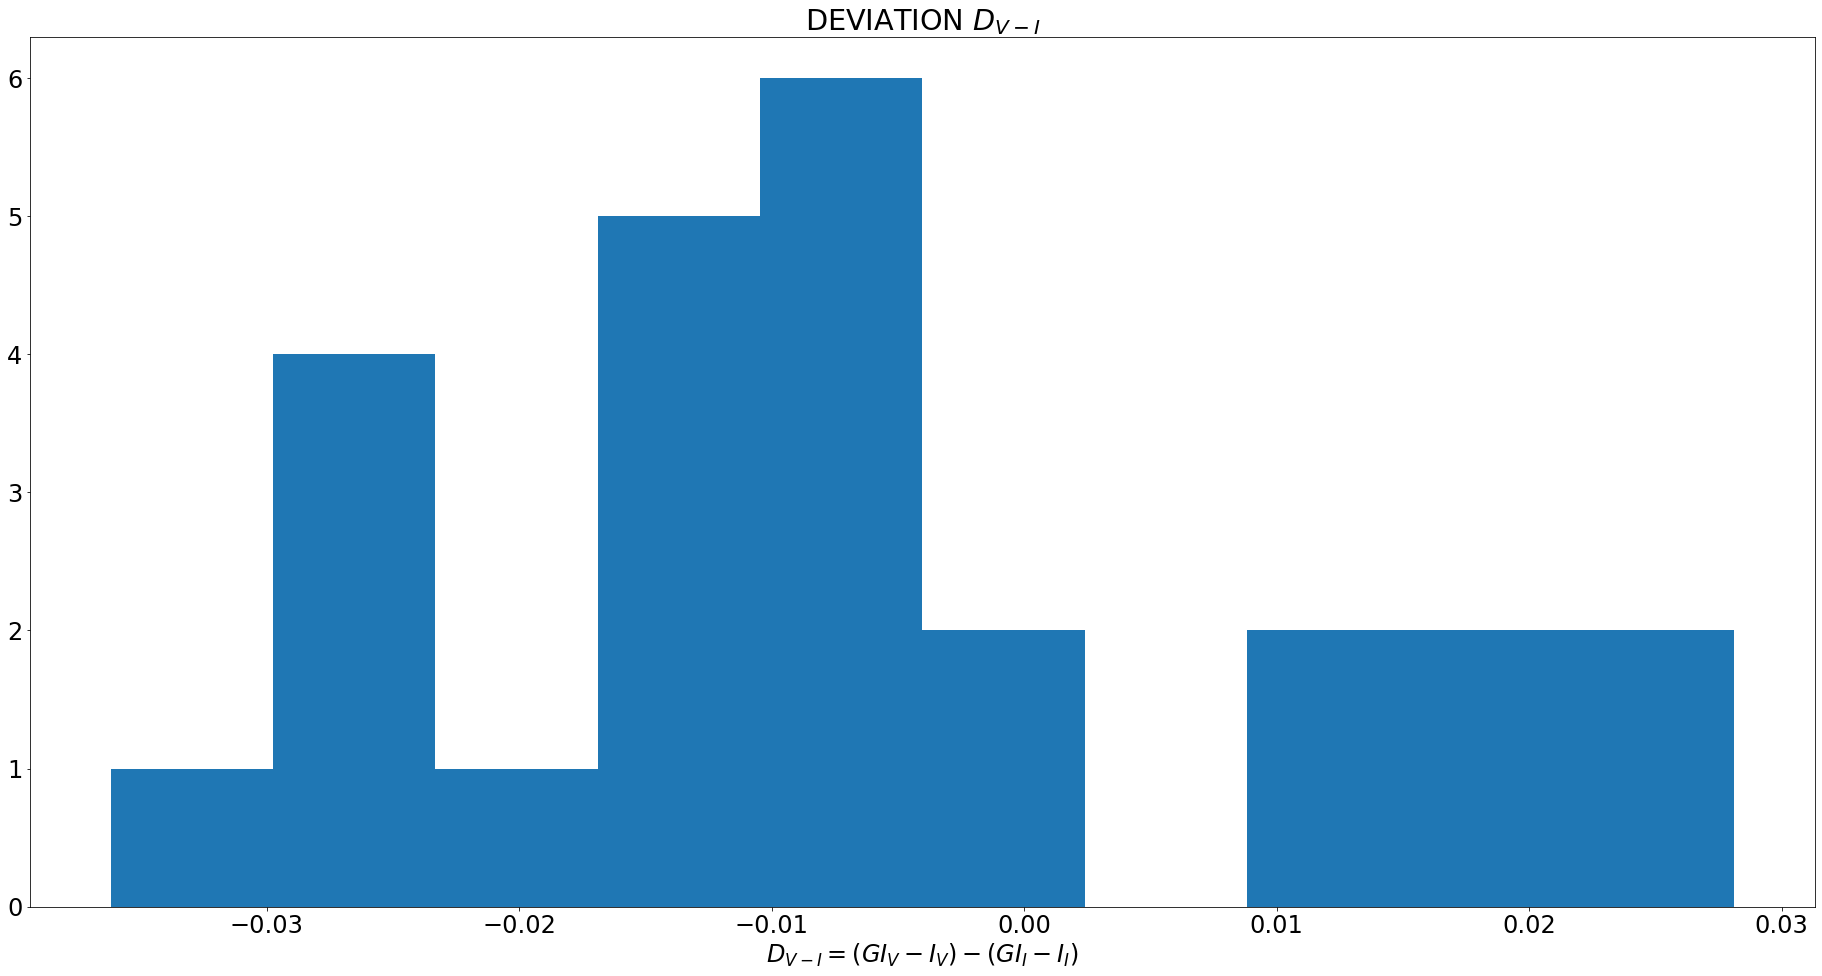

In [27]:
#D_V-I IS CALCULATED AND STORES IN d_v_i AND ITS HISTOGRAM IS PLOTTED
d_v_i = np.subtract(v_grid_icp - v_global_int, i_grid_icp - i_global_int)
plt.figure(figsize=(32,16))
plt.hist(d_v_i)
plt.xlabel("$D_{V-I} = (GI_V - I_V) - (GI_I - I_I)$")
plt.title("DEVIATION $D_{V-I}$")
plt.show()

### Wesenheit Index

Deviations from P-L relation may occur due to a phenomena called interstellar extinction. The Wesenheit Index, defined as `W = I - 1.55(V - I)` automatically takes care of extinction. Show a plot of W vs log(P) for the given data.

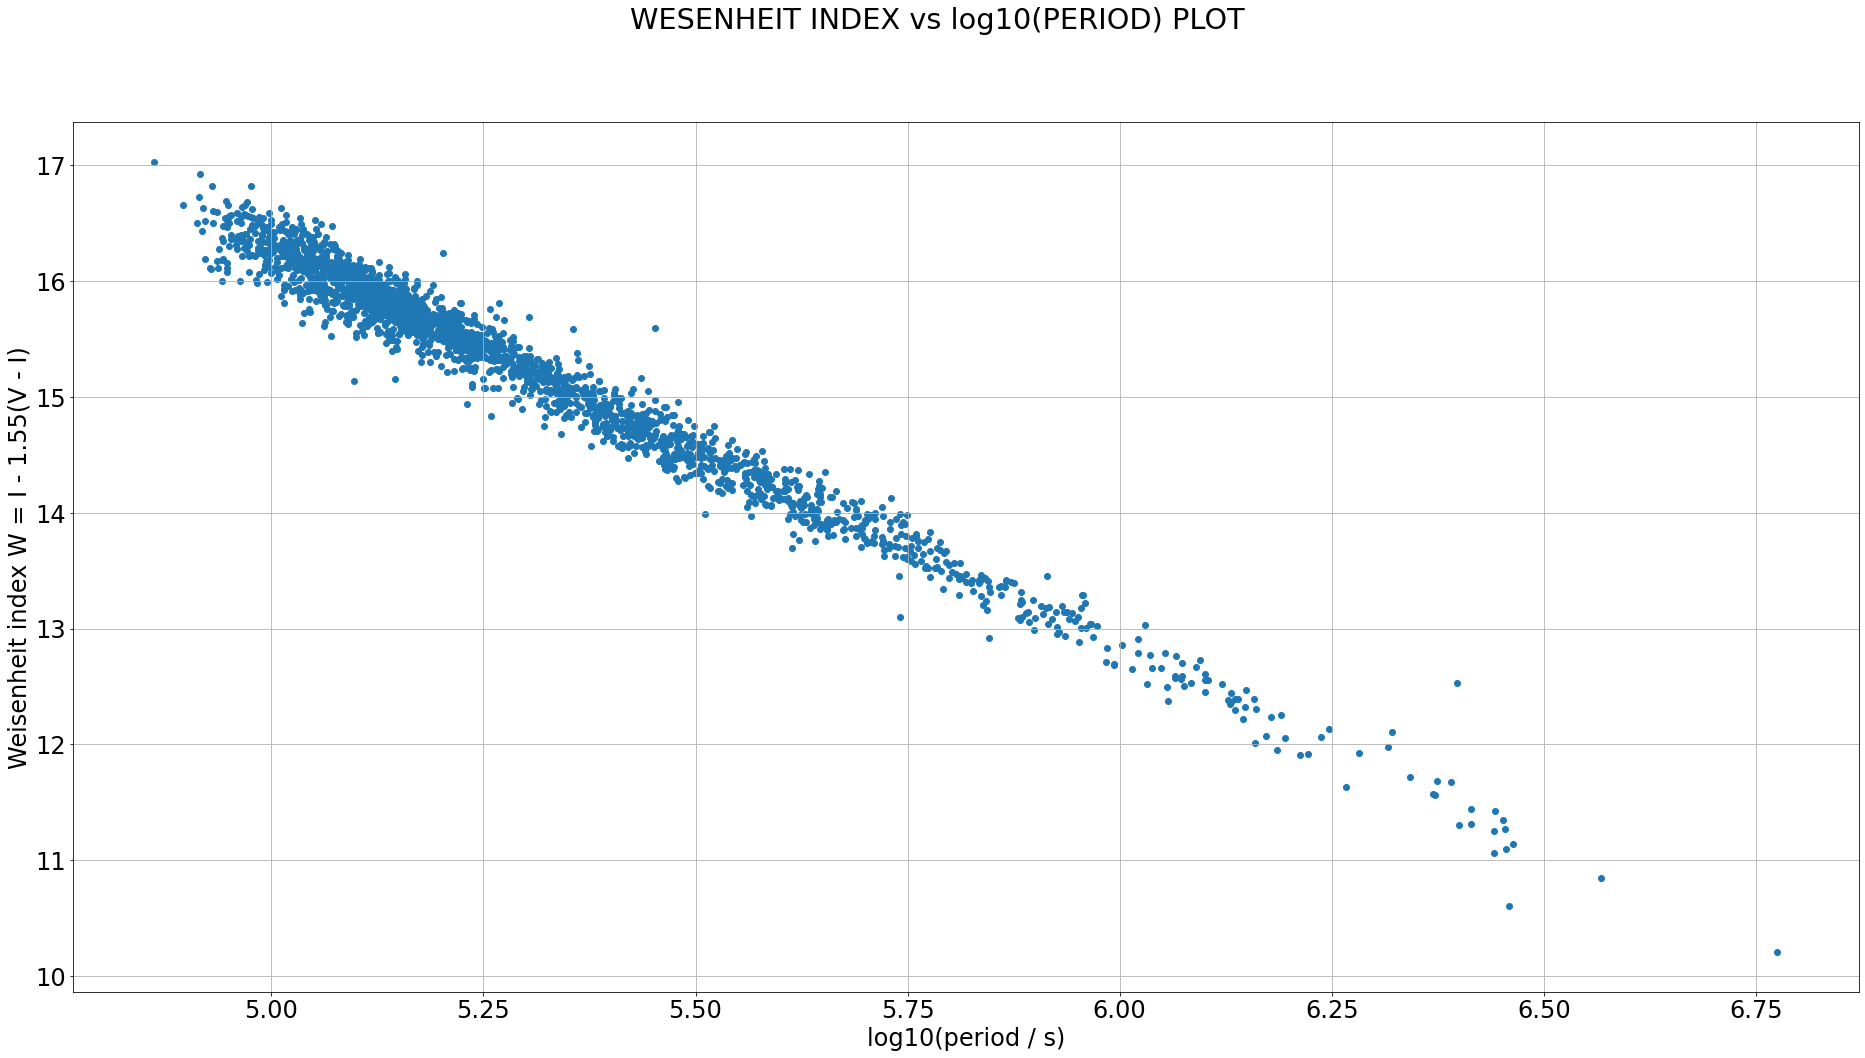

In [28]:
#WESENHEIT INDEX IS STORED IN w
#WESENHEIT INDEX vs log10(PERIOD) IS PLOTTED
w = np.subtract(df.I.values , 1.55 * np.subtract(df.V.values , df.I.values))

plt.figure(figsize=(32,16))
ax = plt.subplot(111)
ax.set_xlabel('log10(period / s)')
ax.set_ylabel('Weisenheit index W = I - 1.55(V - I)')
ax.scatter(df.P_1.values, w)
ax.grid(True, which='both')

plt.suptitle("WESENHEIT INDEX vs log10(PERIOD) PLOT")
plt.show()


### Hints and References:

Magnitude system: [Wikipedia](https://en.wikipedia.org/wiki/Magnitude_(astronomy%29) <br>
Pandas: [Pandas](https://pandas.pydata.org/docs/user_guide/index.html)<br>
Interstellar Extinction: [Wikipedia](https://en.wikipedia.org/wiki/Extinction_(astronomy%29)